In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

import holidays
import itertools
import time
import os
import pickle

from datetime import datetime, date, timedelta
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [102]:
df = pd.read_csv('products_data.csv')
df.head()

date  BEVERAGES  BREAD/BAKERY  CLEANING    DAIRY         DELI  \
0  2015-01-01     3528.0     676.24000     850.0    875.0    357.08200   
1  2015-01-02   111353.0   29702.92898   83431.0  43474.0  20804.69500   
2  2015-01-03   110296.0   29305.08506   83648.0  45711.0  20014.19500   
3  2015-01-04   122463.0   38390.82610   92456.0  56921.0  22452.49399   
4  2015-01-05    88624.0   29377.54303   76070.0  43653.0  15715.71800   

    GROCERY I         MEATS  PERSONAL CARE       POULTRY  PRODUCE  
0    3125.000    479.767000          203.0    279.169980    105.0  
1  245045.337  24370.203999        23581.0  26814.086005    756.0  
2  242694.753  21044.533846        24531.0  24995.854050    595.0  
3  281467.988  22198.505007        27428.0  27507.856975    272.0  
4  225516.495  16451.880920        20566.0  20565.498000     72.0

In [103]:
date_df = df[['date']]
df = df.drop('date', axis=1)
df.head()

BEVERAGES  BREAD/BAKERY  CLEANING    DAIRY         DELI   GROCERY I  \
0     3528.0     676.24000     850.0    875.0    357.08200    3125.000   
1   111353.0   29702.92898   83431.0  43474.0  20804.69500  245045.337   
2   110296.0   29305.08506   83648.0  45711.0  20014.19500  242694.753   
3   122463.0   38390.82610   92456.0  56921.0  22452.49399  281467.988   
4    88624.0   29377.54303   76070.0  43653.0  15715.71800  225516.495   

          MEATS  PERSONAL CARE       POULTRY  PRODUCE  
0    479.767000          203.0    279.169980    105.0  
1  24370.203999        23581.0  26814.086005    756.0  
2  21044.533846        24531.0  24995.854050    595.0  
3  22198.505007        27428.0  27507.856975    272.0  
4  16451.880920        20566.0  20565.498000     72.0

In [48]:
# Define parameter ranges
changepoint_range = [0.001, 0.01, 0.1, 0.5]
seasonality_range = [0.01, 0.1, 1.0, 10.0]

# Combine parameters into a grid
param_grid = {
    "changepoint_prior_scale": changepoint_range,
    "seasonality_prior_scale": seasonality_range
}

# Track the best parameters for each feature
best_params_dict = {}

# Start timer
start_time = time.time()

# Loop through each column in df
for column in df.columns:
    print(f"Processing feature: {column}")

    # Prepare data
    category_df = df[[column]].copy()
    category_df["ds"] = pd.to_datetime(date_df["date"])
    category_df.rename(columns={column:'y'}, inplace=True)

    # Generate all parameter combinations
    param_combinations = [
        dict(zip(param_grid.keys(), values)) 
        for values in itertools.product(*param_grid.values())
    ]
    
    mapes = []
    rmses = []

    # Evaluate each parameter combination
    for params in param_combinations:
    
        # Fit the model
        model = Prophet(**params)
        model.fit(category_df)

        # Perform cross-validation
        df_cv = cross_validation(model, initial="365 days", period="30 days", horizon="30 days")

        # Calculate performance metrics
        df_perf = performance_metrics(df_cv, rolling_window=1)
        mapes.append(df_perf["mape"].values[0])
        rmses.append(df_perf["rmse"].values[0])
    
    # Store results
    tuning_results = pd.DataFrame(param_combinations)
    tuning_results["mape"] = mapes
    tuning_results["rmse"] = rmses

    # Get best parameters (lowest MAPE)
    best_params = tuning_results.sort_values("mape").iloc[0].to_dict()
    best_params["feature"] = column
    best_params_dict[column] = best_params

    print(f"Best params for {column}: {best_params}")

# Print total runtime
print(f"--- {time.time() - start_time:.2f} ---")

# Convert results to a DataFrame if needed
best_params_df = pd.DataFrame(best_params_dict).T


Processing feature: BEVERAGES


13:48:10 - cmdstanpy - INFO - Chain [1] start processing
13:48:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
13:48:12 - cmdstanpy - INFO - Chain [1] start processing
13:48:12 - cmdstanpy - INFO - Chain [1] done processing
13:48:13 - cmdstanpy - INFO - Chain [1] start processing
13:48:13 - cmdstanpy - INFO - Chain [1] done processing
13:48:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:48:13 - cmdstanpy - INFO - Chain [1] start processing
13:48:15 - cmdstanpy - INFO - Chain [1] done processing
13:48:16 - cmdstanpy - INFO - Chain [1] start processing
13:48:16 - cmdstanpy - INFO - Chain [1] done processing
13:48:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:48:16 - cmdstanp

Best params for BEVERAGES: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'mape': 0.23733002594655514, 'rmse': 32147.04928576067, 'feature': 'BEVERAGES'}
Processing feature: BREAD/BAKERY


13:57:23 - cmdstanpy - INFO - Chain [1] start processing
13:57:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
13:57:24 - cmdstanpy - INFO - Chain [1] start processing
13:57:24 - cmdstanpy - INFO - Chain [1] done processing
13:57:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:57:24 - cmdstanpy - INFO - Chain [1] start processing
13:57:27 - cmdstanpy - INFO - Chain [1] done processing
13:57:28 - cmdstanpy - INFO - Chain [1] start processing
13:57:28 - cmdstanpy - INFO - Chain [1] done processing
13:57:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:57:28 - cmdstanpy - INFO - Chain [1] start processing
13:57:33 - cmdstanpy - INFO - Chain [1] done processing
13:57:33 - cmdstanp

Best params for BREAD/BAKERY: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'mape': 0.20236471035370696, 'rmse': 3403.0685879419475, 'feature': 'BREAD/BAKERY'}
Processing feature: CLEANING


14:08:07 - cmdstanpy - INFO - Chain [1] start processing
14:08:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:08:08 - cmdstanpy - INFO - Chain [1] start processing
14:08:08 - cmdstanpy - INFO - Chain [1] done processing
14:08:09 - cmdstanpy - INFO - Chain [1] start processing
14:08:09 - cmdstanpy - INFO - Chain [1] done processing
14:08:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:08:09 - cmdstanpy - INFO - Chain [1] start processing
14:08:12 - cmdstanpy - INFO - Chain [1] done processing
14:08:12 - cmdstanpy - INFO - Chain [1] start processing
14:08:13 - cmdstanpy - INFO - Chain [1] done processing
14:08:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:08:13 - cmdstanp

Best params for CLEANING: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'mape': 0.47662603800928244, 'rmse': 11247.862123698218, 'feature': 'CLEANING'}
Processing feature: DAIRY


14:14:44 - cmdstanpy - INFO - Chain [1] start processing
14:14:44 - cmdstanpy - INFO - Chain [1] done processing
14:14:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:14:44 - cmdstanpy - INFO - Chain [1] start processing
14:14:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:14:49 - cmdstanpy - INFO - Chain [1] start processing
14:14:50 - cmdstanpy - INFO - Chain [1] done processing
14:14:50 - cmdstanpy - INFO - Chain [1] start processing
14:14:51 - cmdstanpy - INFO - Chain [1] done processing
14:14:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:14:51 - cmdstanpy - INFO - Chain [1] start processing
14:15:02 - cmdstanpy - INFO - Chain [1] done processing
14:15:03 - cmdstanp

Best params for DAIRY: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'mape': 0.2684527198630399, 'rmse': 6230.462022502382, 'feature': 'DAIRY'}
Processing feature: DELI


14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:24:44 - cmdstanpy - INFO - Chain [1] start processing
14:24:44 - cmdstanpy - INFO - Chain [1] done processing
14:24:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:24:44 - cmdstanpy - INFO - Chain [1] start processing
14:24:46 - cmdstanpy - INFO - Chain [1] done processing
14:24:46 - cmdstanpy - INFO - Chain [1] start processing
14:24:46 - cmdstanpy - INFO - Chain [1] done processing
14:24:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:24:46 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing
14:24:48 - cmdstanp

Best params for DELI: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'mape': 0.2931424529583792, 'rmse': 2662.820511486007, 'feature': 'DELI'}
Processing feature: GROCERY I


14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:31:56 - cmdstanpy - INFO - Chain [1] start processing
14:31:56 - cmdstanpy - INFO - Chain [1] done processing
14:31:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:31:57 - cmdstanpy - INFO - Chain [1] start processing
14:31:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanp

Best params for GROCERY I: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'mape': 0.4002081232294403, 'rmse': 46030.89965941516, 'feature': 'GROCERY I'}
Processing feature: MEATS


14:39:27 - cmdstanpy - INFO - Chain [1] start processing
14:39:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:39:28 - cmdstanpy - INFO - Chain [1] start processing
14:39:29 - cmdstanpy - INFO - Chain [1] done processing
14:39:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:39:29 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] done processing
14:39:42 - cmdstanp

Best params for MEATS: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'mape': 0.23128365413302215, 'rmse': 4512.438861700449, 'feature': 'MEATS'}
Processing feature: PERSONAL CARE


14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:47:31 - cmdstanpy - INFO - Chain [1] start processing
14:47:32 - cmdstanpy - INFO - Chain [1] done processing
14:47:32 - cmdstanpy - INFO - Chain [1] start processing
14:47:32 - cmdstanpy - INFO - Chain [1] done processing
14:47:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:38 - cmdstanpy - INFO - Chain [1] done processing
14:47:39 - cmdstanpy - INFO - Chain [1] start processing
14:47:39 - cmdstanpy - INFO - Chain [1] done processing
14:47:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:47:39 - cmdstanp

Best params for PERSONAL CARE: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'mape': 0.461272109221434, 'rmse': 4104.114724928355, 'feature': 'PERSONAL CARE'}
Processing feature: POULTRY


14:55:02 - cmdstanpy - INFO - Chain [1] start processing
14:55:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:55:02 - cmdstanpy - INFO - Chain [1] start processing
14:55:03 - cmdstanpy - INFO - Chain [1] done processing
14:55:04 - cmdstanpy - INFO - Chain [1] start processing
14:55:04 - cmdstanpy - INFO - Chain [1] done processing
14:55:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:55:04 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:07 - cmdstanpy - INFO - Chain [1] done processing
14:55:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:55:07 - cmdstanp

Best params for POULTRY: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'mape': 0.39260473788962863, 'rmse': 3087.948447175716, 'feature': 'POULTRY'}
Processing feature: PRODUCE


15:03:34 - cmdstanpy - INFO - Chain [1] start processing
15:03:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:03:35 - cmdstanpy - INFO - Chain [1] start processing
15:03:35 - cmdstanpy - INFO - Chain [1] done processing
15:03:36 - cmdstanpy - INFO - Chain [1] start processing
15:03:36 - cmdstanpy - INFO - Chain [1] done processing
15:03:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:03:36 - cmdstanpy - INFO - Chain [1] start processing
15:03:38 - cmdstanpy - INFO - Chain [1] done processing
15:03:39 - cmdstanpy - INFO - Chain [1] start processing
15:03:39 - cmdstanpy - INFO - Chain [1] done processing
15:03:40 - cmdstanpy - INFO - Chain [1] start processing
15:03:41 - cmdstanpy - INFO - Chain [1] done processing
15:03:41 - cmdstanpy - ERROR - Chain [1] error: error during p

Best params for PRODUCE: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'mape': 0.25753545963532626, 'rmse': 18110.242464691866, 'feature': 'PRODUCE'}
--- 5073.61 ---


In [62]:
best_params_dict = best_params_df.to_dict(orient='index')
best_params_dict

{'BEVERAGES': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.23733002594655514,
  'rmse': 32147.04928576067,
  'feature': 'BEVERAGES'},
 'BREAD/BAKERY': {'changepoint_prior_scale': 0.01,
  'seasonality_prior_scale': 0.01,
  'mape': 0.20236471035370696,
  'rmse': 3403.0685879419475,
  'feature': 'BREAD/BAKERY'},
 'CLEANING': {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 0.01,
  'mape': 0.47662603800928244,
  'rmse': 11247.862123698218,
  'feature': 'CLEANING'},
 'DAIRY': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 10.0,
  'mape': 0.2684527198630399,
  'rmse': 6230.462022502382,
  'feature': 'DAIRY'},
 'DELI': {'changepoint_prior_scale': 0.01,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2931424529583792,
  'rmse': 2662.820511486007,
  'feature': 'DELI'},
 'GROCERY I': {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 10.0,
  'mape': 0.4002081232294403,
  'rmse': 46030.89965941516,
  'feature': 'GROCERY I'},

In [82]:
#adding holiday data
holiday_df = pd.DataFrame([])

ecuador_holidays = holidays.EC() # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict

for date_, name in sorted(holidays.EC(years=[2015, 2016, 2017]).items()):
    holiday_df = pd.concat([holiday_df, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday_df['ds'] = pd.to_datetime(holiday_df['ds'], format='%Y-%m-%d', errors='ignore')
holiday_df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_19756\1241628201.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday_df['ds'] = pd.to_datetime(holiday_df['ds'], format='%Y-%m-%d', errors='ignore')


ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

In [100]:
# Directory to save models
model_save_dir = "./ssaved_models2"
os.makedirs(model_save_dir, exist_ok=True)

# Define prediction settings
prediction_days = 30
forecast_start_date = date(2017, 7, 1)
forecast_start_date = forecast_start_date.strftime('%Y-%m-%d')

forecasted_features = []

# Loop through each column in df
for column in df.columns:
    print(f"Processing feature: {column}")

    # Prepare data
    category_df = df[[column]].copy()
    category_df["ds"] = pd.to_datetime(date_df["date"])
    category_df.rename(columns={column: 'y'}, inplace=True)
    
    # Split the data into training and test datasets
    # Train only on historical data before forecast_start_date
    train_data = category_df[category_df["ds"] < forecast_start_date]
    
    # Train the Prophet model
    m = Prophet(changepoint_prior_scale=best_params_dict[column]['changepoint_prior_scale'],
                seasonality_prior_scale=best_params_dict[column]['seasonality_prior_scale'],
                seasonality_mode='multiplicative',
                holidays=holiday_df)
    
    m.fit(train_data)

    # Save the trained model
    sanitized_feature = column.replace("/", "_").replace("\\", "_")
    model_path = os.path.join(model_save_dir, f"{sanitized_feature}_prophet_model.pkl")
    with open(model_path, 'wb') as f:
        pickle.dump(m, f)
    print(f"Saved model for feature: {column} at {model_path}")

    # Generate future dates and make predictions
    future = m.make_future_dataframe(periods=prediction_days)
    forecast = m.predict(future)
    
    # Filter forecasted dates
    forecasted_dates_df = forecast[forecast['ds'] >= forecast_start_date]
    predicted_df = forecasted_dates_df[['ds', 'yhat']]
    
    # Evaluate the model using the test data (after forecast_start_date)
    test_data = category_df[category_df['ds'] >= pd.to_datetime(forecast_start_date)]
    
    # Merge predictions with actual test data (ytrue)
    df_result = predicted_df.merge(test_data, on='ds', how='left')
    mape = mean_absolute_percentage_error(df_result['ytrue'], df_result['yhat'])
    print(f"Feature: {column}, MAPE: {mape:.4f}")
    
    # Plot forecasts and components
    fig1 = m.plot(forecast)
    fig1.suptitle(f"Feature: {column}", fontsize=16)
    fig2 = m.plot_components(forecast)
    fig2.suptitle(f"Components for Feature: {column}", fontsize=16)
    forecasted_features.append(forecasted_dates_df)

# Save all forecasts if needed
print("All models and forecasts completed.")


Processing feature: date


KeyError: 'date'

In [101]:
df

date  BEVERAGES  BREAD/BAKERY  CLEANING    DAIRY          DELI  \
0    2015-01-01     3528.0     676.24000     850.0    875.0    357.082000   
1    2015-01-02   111353.0   29702.92898   83431.0  43474.0  20804.695000   
2    2015-01-03   110296.0   29305.08506   83648.0  45711.0  20014.195000   
3    2015-01-04   122463.0   38390.82610   92456.0  56921.0  22452.493990   
4    2015-01-05    88624.0   29377.54303   76070.0  43653.0  15715.718000   
..          ...        ...           ...       ...      ...           ...   
951  2017-08-11   189111.0   28204.48600   55682.0  44909.0  18680.488004   
952  2017-08-12   182318.0   27403.54800   57935.0  42854.0  15689.893010   
953  2017-08-13   202354.0   33262.75700   61757.0  50112.0  17593.274020   
954  2017-08-14   174832.0   28002.45700   55032.0  43050.0  14662.741000   
955  2017-08-15   170773.0   29158.19502   58474.0  40707.0  14935.453000   

      GROCERY I         MEATS  PERSONAL CARE       POULTRY       PRODUCE  
0      3125.000    479.767000          203.0    279.169980     105.00000  
1    245045.337  24370.203999        23581.0  26814.086005     756.00000  
2    242694.753  21044.533846        24531.0  24995.854050     595.00000  
3    281467.988  22198.505007        27428.0  27507.856975     272.00000  
4    225516.495  16451.880920        20566.0  20565.498000      72.00000  
..          ...           ...            ...           ...           ...  
951  238221.922  26944.092010        15978.0  25318.297990  118738.14300  
952  238627.633  17775.650112        15903.0  19134.510058  111788.35090  
953  258442.452  18633.015039        18188.0  20509.265004  125923.80240  
954  225355.694  16975.686040        15077.0  18597.508060  115257.59598  
955  224208.125  17928.170944        14787.0  17586.709986  125108.97100  

[956 rows x 11 columns]

Processing feature: BEVERAGES


17:48:44 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing


Saved model for feature: BEVERAGES at ./saved_models\BEVERAGES_prophet_model.pkl
Feature: BEVERAGES, MAPE: 0.0767
Processing feature: BREAD/BAKERY


17:48:48 - cmdstanpy - INFO - Chain [1] start processing
17:48:49 - cmdstanpy - INFO - Chain [1] done processing


Saved model for feature: BREAD/BAKERY at ./saved_models\BREAD_BAKERY_prophet_model.pkl
Feature: BREAD/BAKERY, MAPE: 0.0611
Processing feature: CLEANING


17:48:52 - cmdstanpy - INFO - Chain [1] start processing
17:48:53 - cmdstanpy - INFO - Chain [1] done processing


Saved model for feature: CLEANING at ./saved_models\CLEANING_prophet_model.pkl
Feature: CLEANING, MAPE: 0.1639
Processing feature: DAIRY


17:48:56 - cmdstanpy - INFO - Chain [1] start processing
17:48:56 - cmdstanpy - INFO - Chain [1] done processing


Saved model for feature: DAIRY at ./saved_models\DAIRY_prophet_model.pkl
Feature: DAIRY, MAPE: 0.0648
Processing feature: DELI


17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing


Saved model for feature: DELI at ./saved_models\DELI_prophet_model.pkl
Feature: DELI, MAPE: 0.0852
Processing feature: GROCERY I


17:49:03 - cmdstanpy - INFO - Chain [1] start processing
17:49:03 - cmdstanpy - INFO - Chain [1] done processing


Saved model for feature: GROCERY I at ./saved_models\GROCERY I_prophet_model.pkl
Feature: GROCERY I, MAPE: 0.0810
Processing feature: MEATS


17:49:06 - cmdstanpy - INFO - Chain [1] start processing
17:49:06 - cmdstanpy - INFO - Chain [1] done processing


Saved model for feature: MEATS at ./saved_models\MEATS_prophet_model.pkl
Feature: MEATS, MAPE: 0.0703
Processing feature: PERSONAL CARE


17:49:09 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing


Saved model for feature: PERSONAL CARE at ./saved_models\PERSONAL CARE_prophet_model.pkl
Feature: PERSONAL CARE, MAPE: 0.1551
Processing feature: POULTRY


17:49:12 - cmdstanpy - INFO - Chain [1] start processing
17:49:13 - cmdstanpy - INFO - Chain [1] done processing


Saved model for feature: POULTRY at ./saved_models\POULTRY_prophet_model.pkl
Feature: POULTRY, MAPE: 0.0934
Processing feature: PRODUCE


17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:18 - cmdstanpy - INFO - Chain [1] done processing


Saved model for feature: PRODUCE at ./saved_models\PRODUCE_prophet_model.pkl
Feature: PRODUCE, MAPE: 0.0539
All models and forecasts completed.


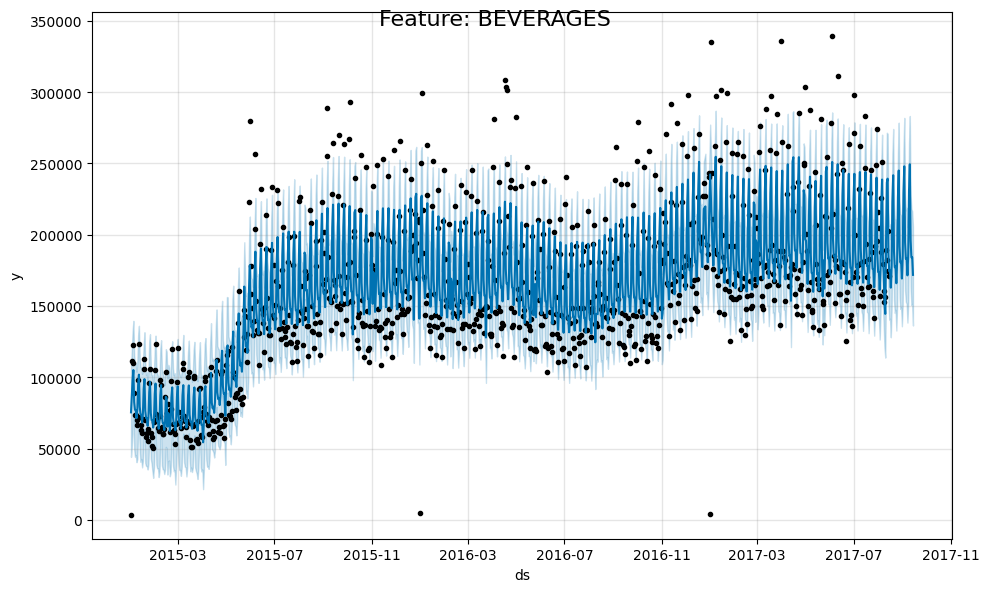

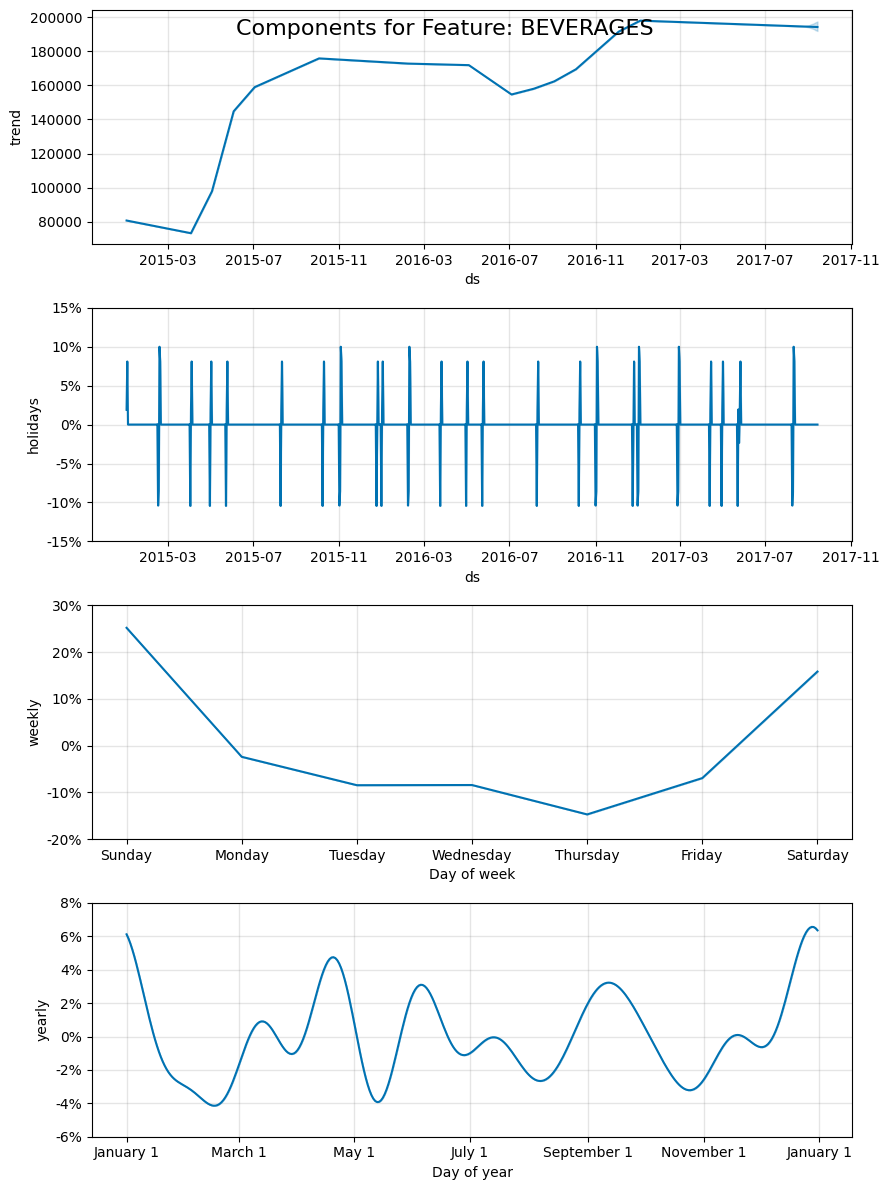

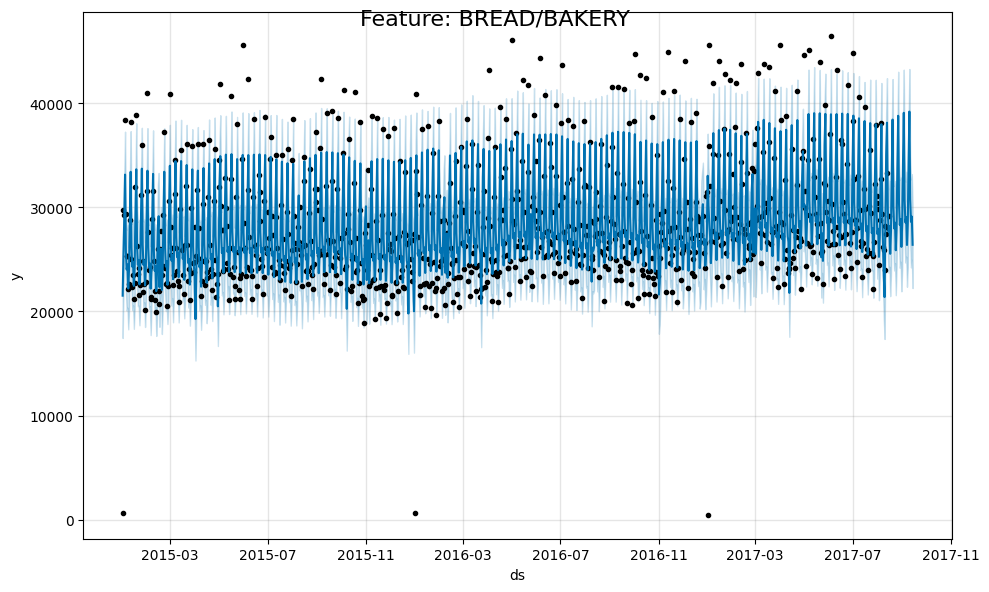

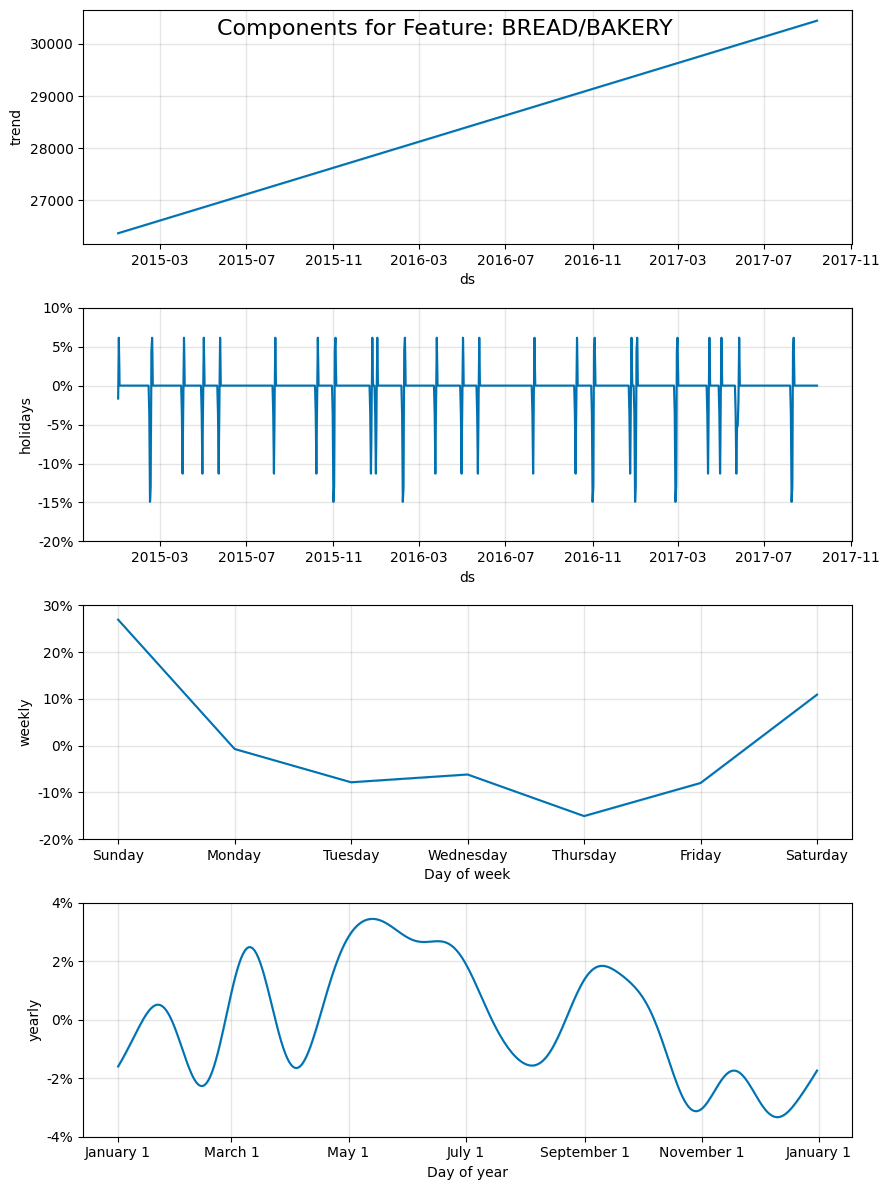

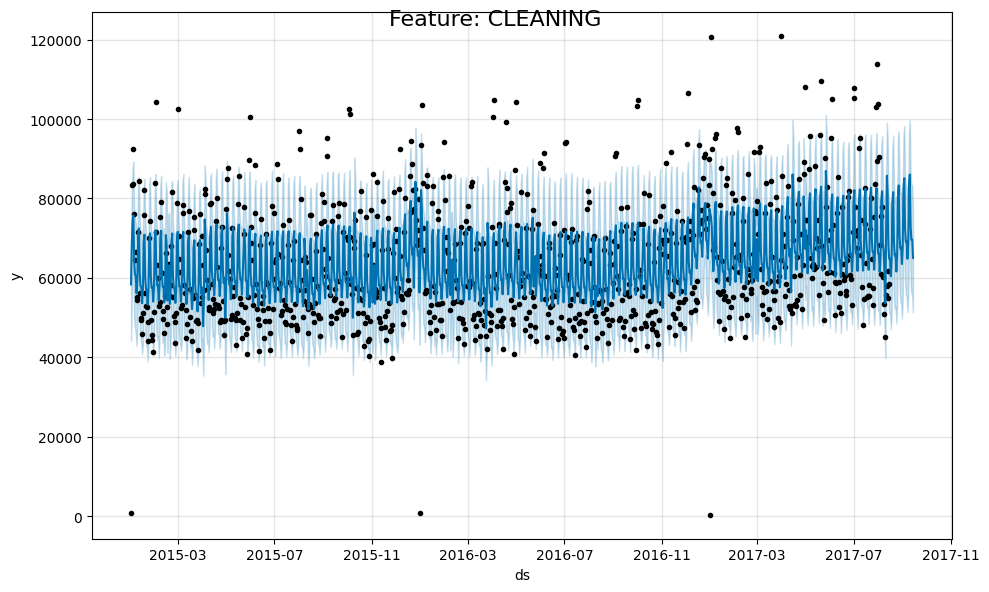

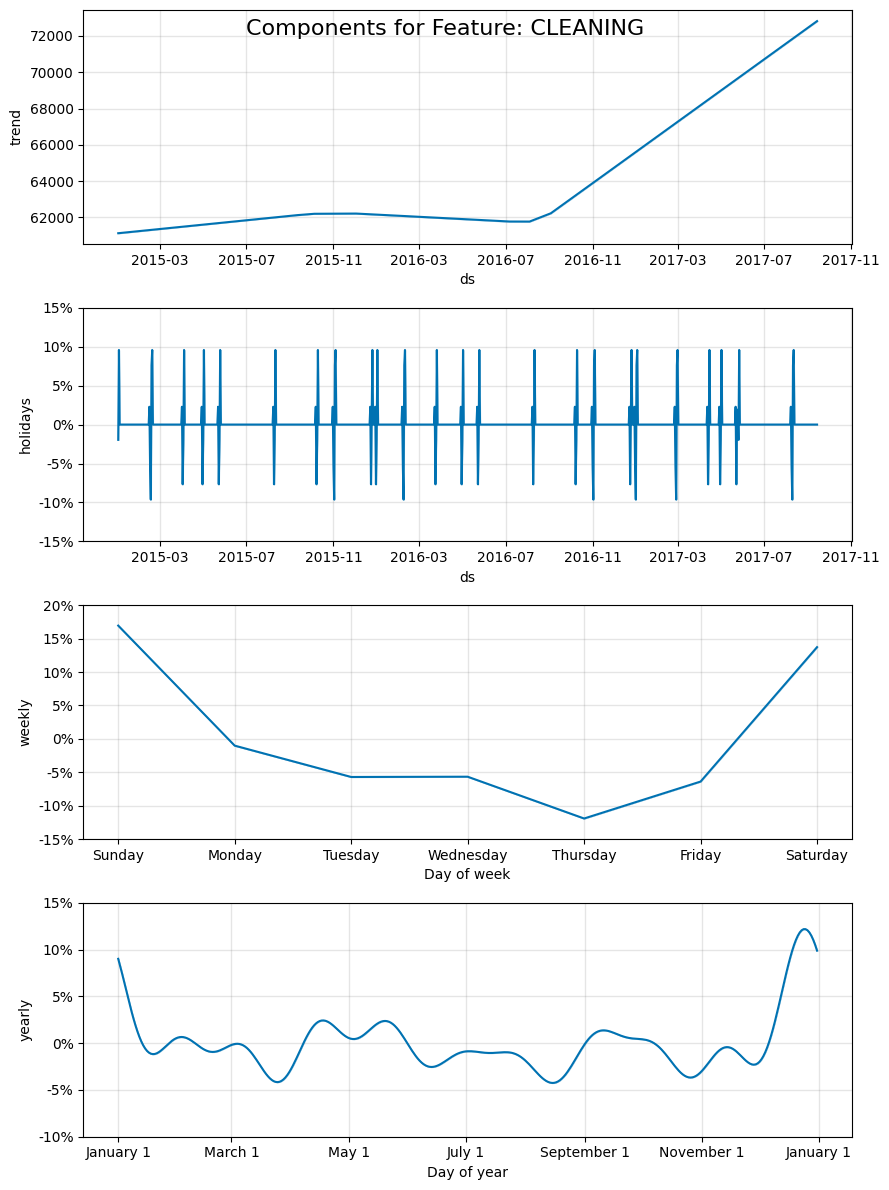

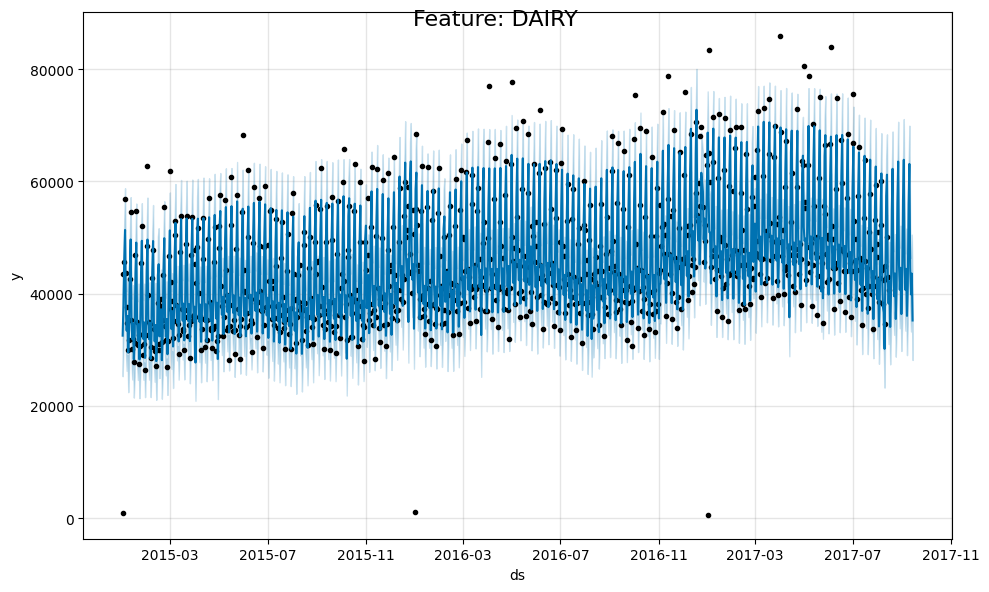

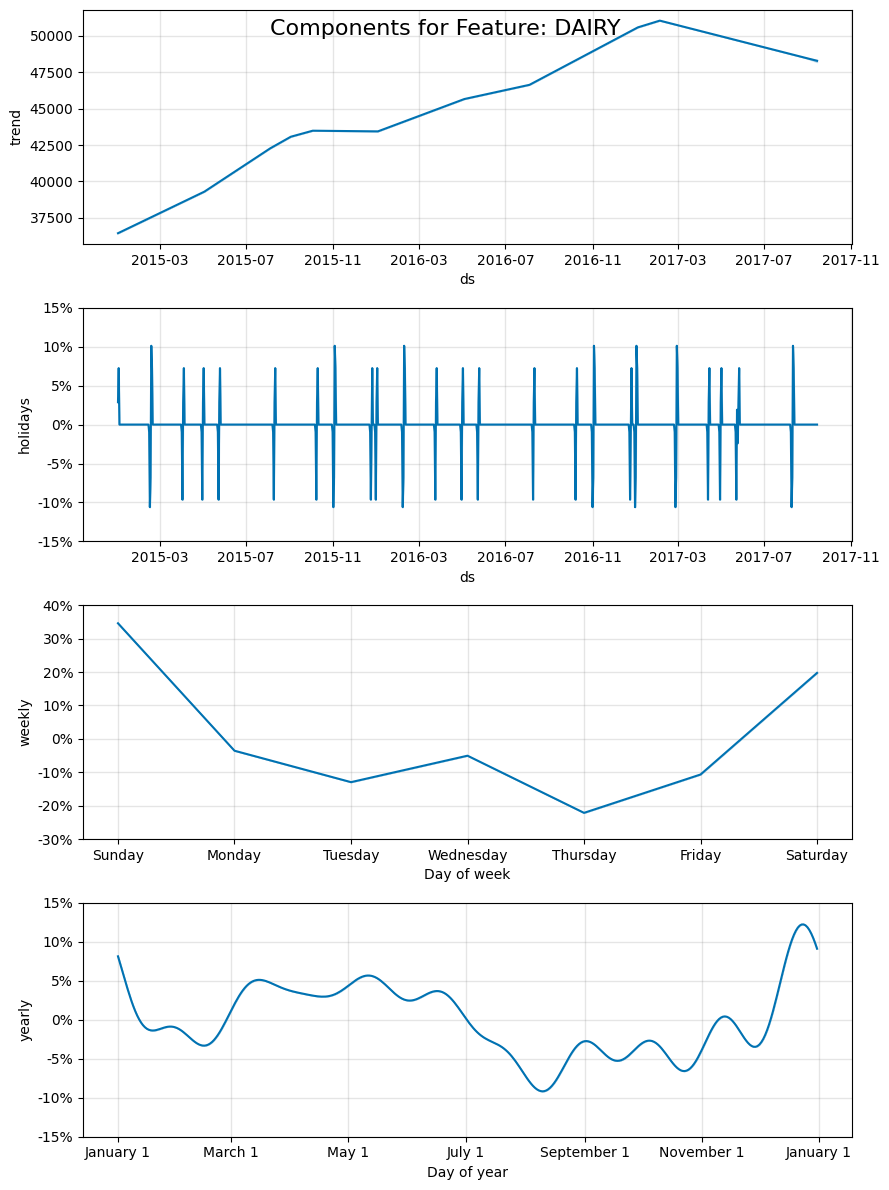

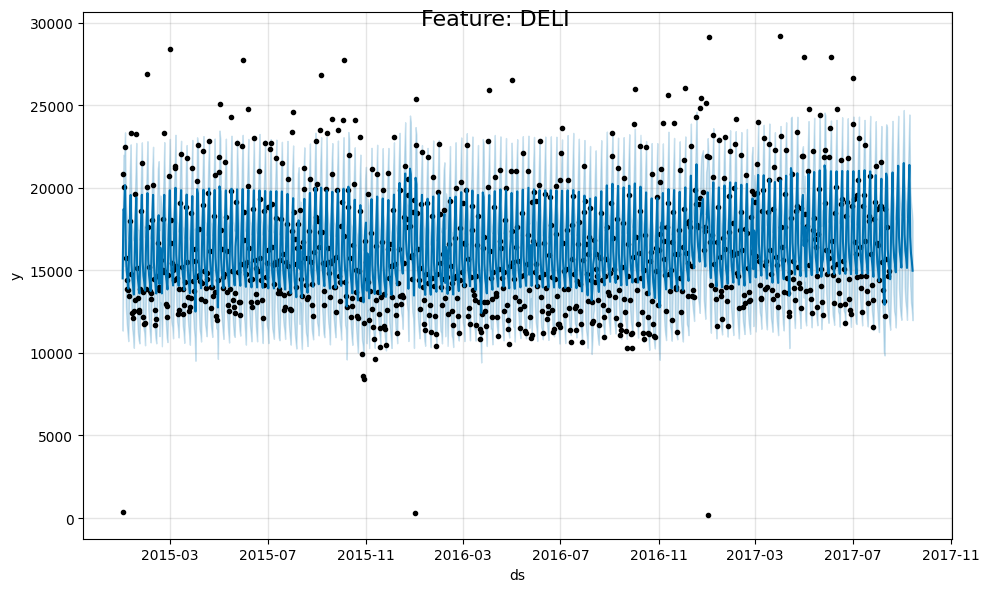

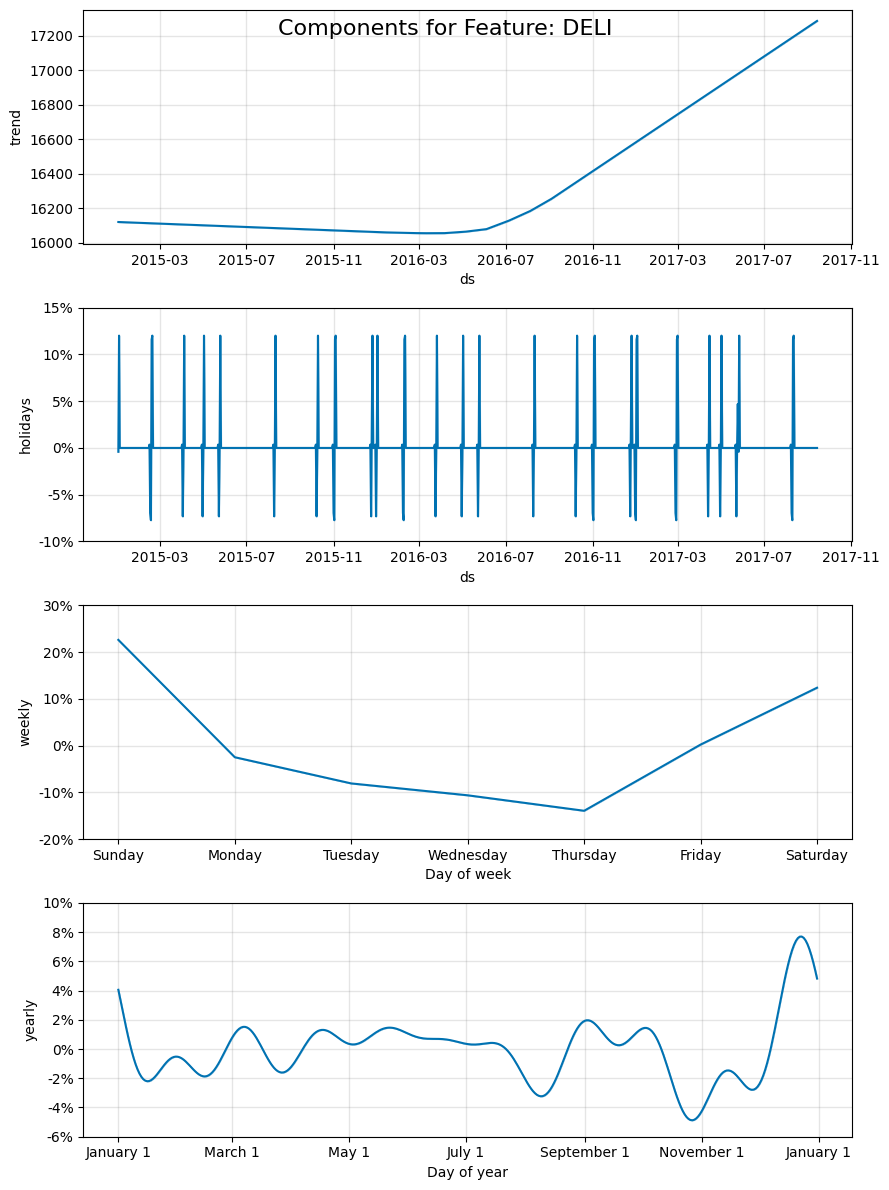

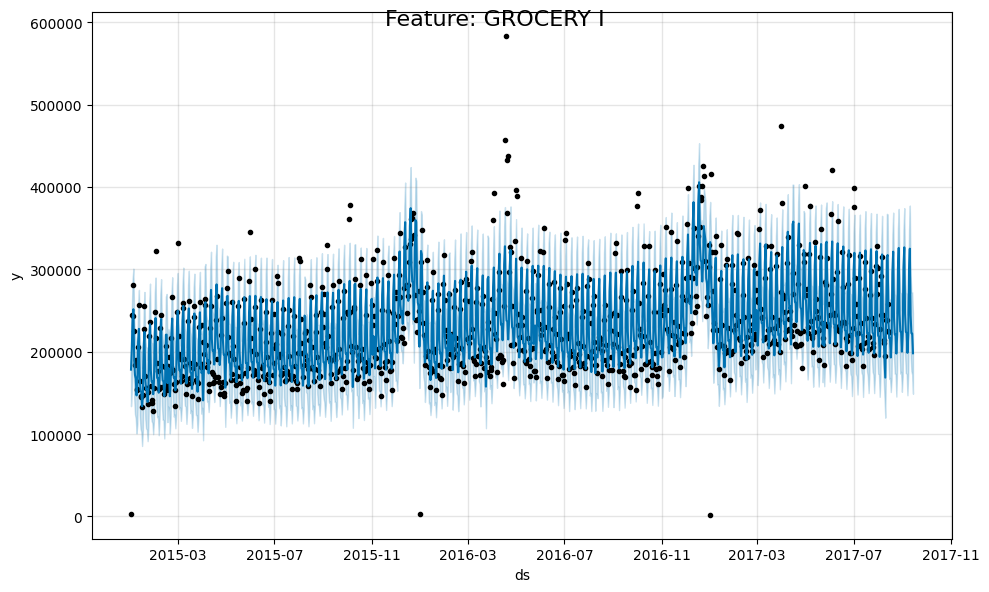

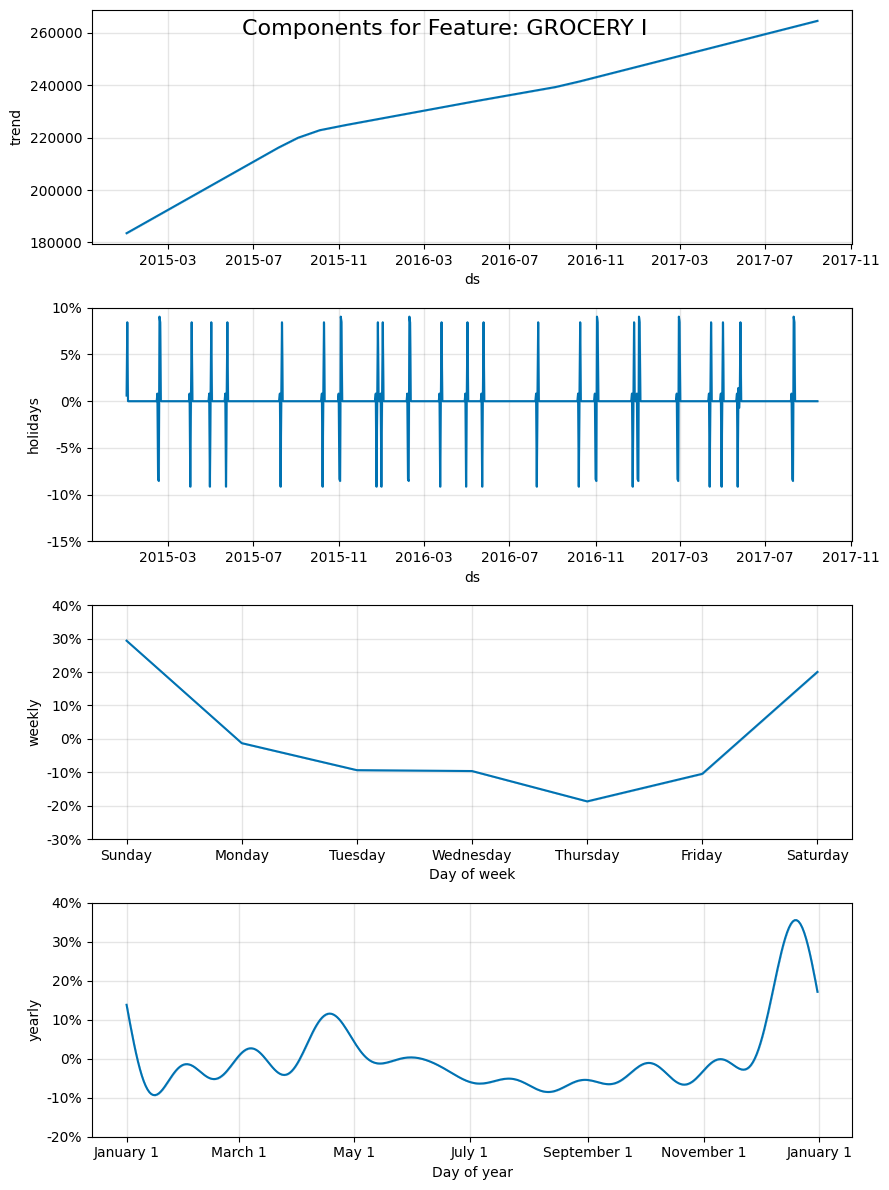

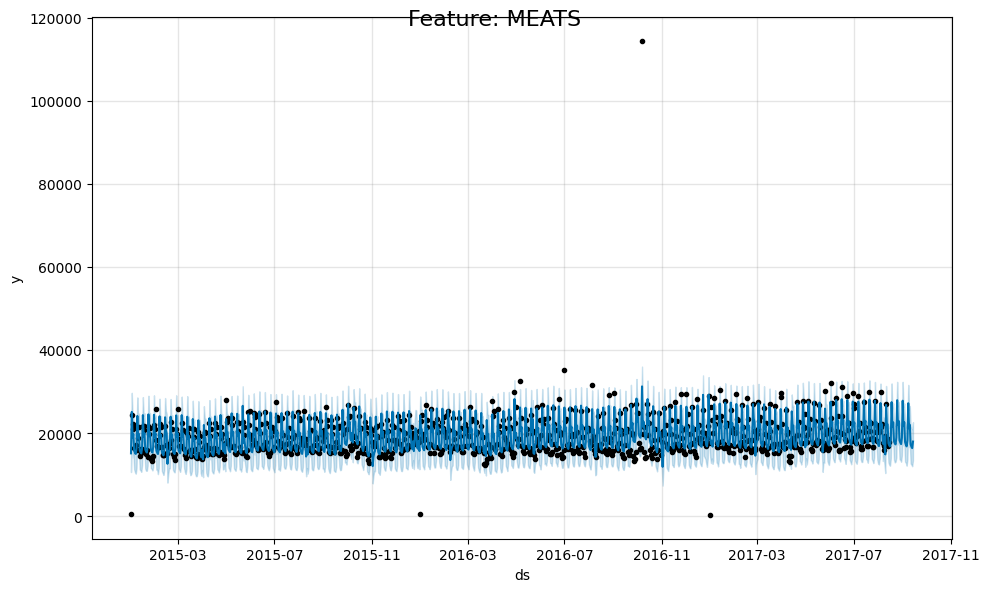

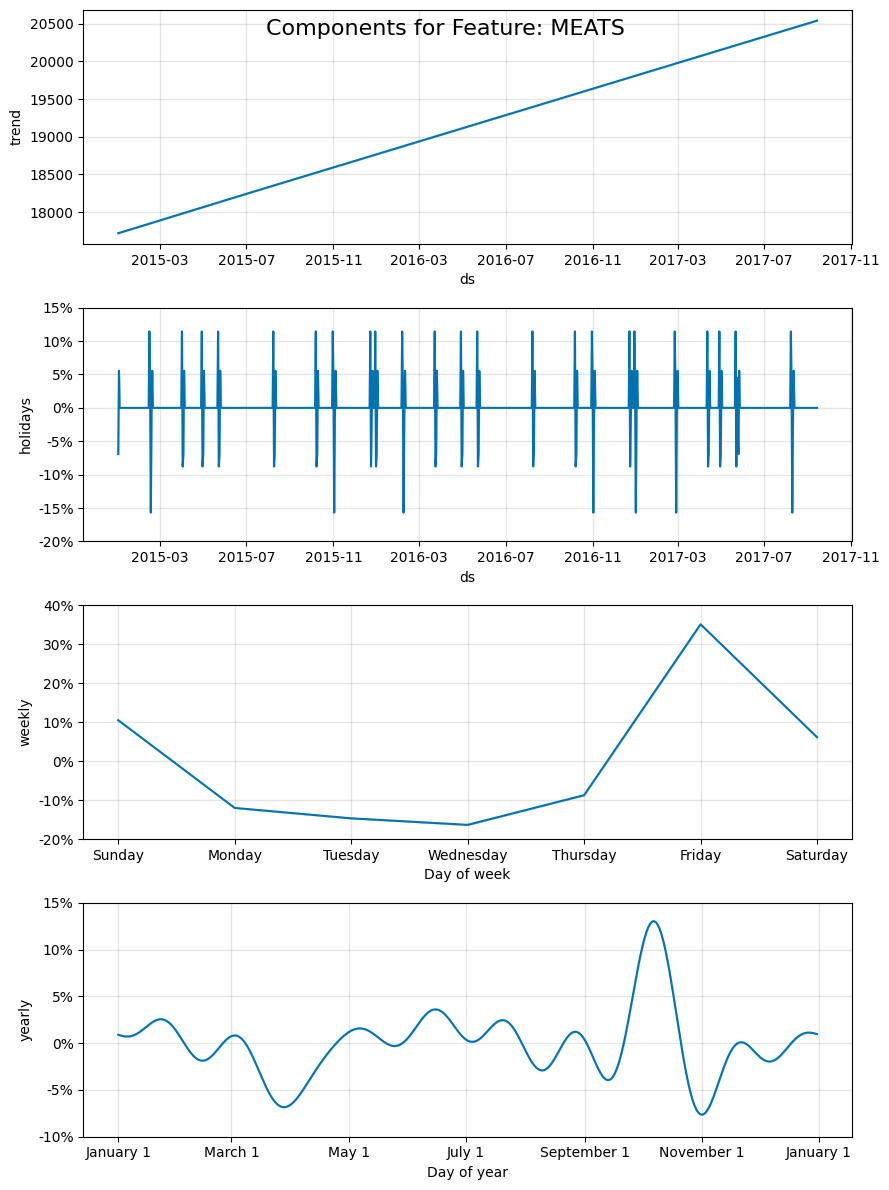

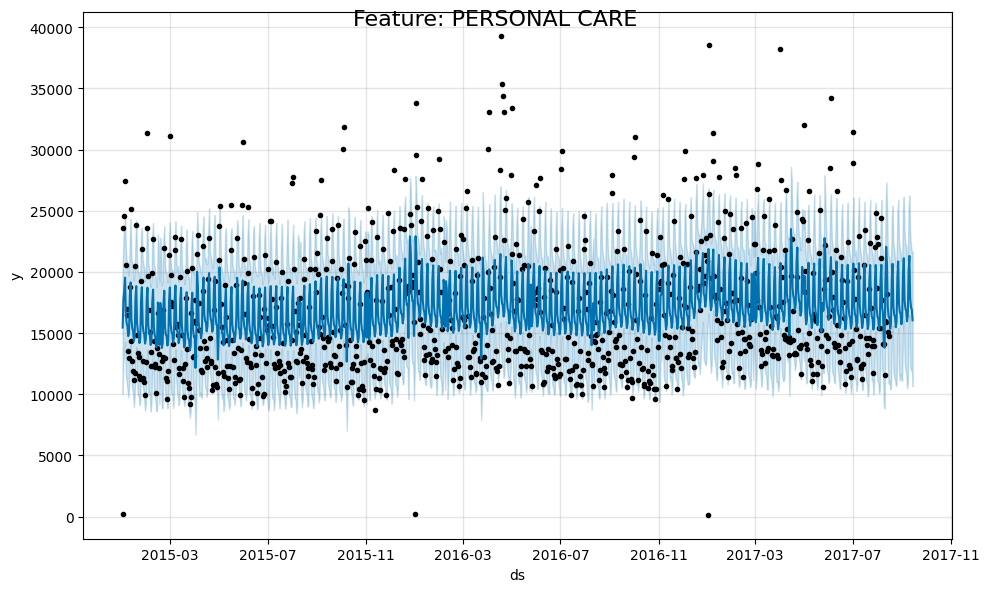

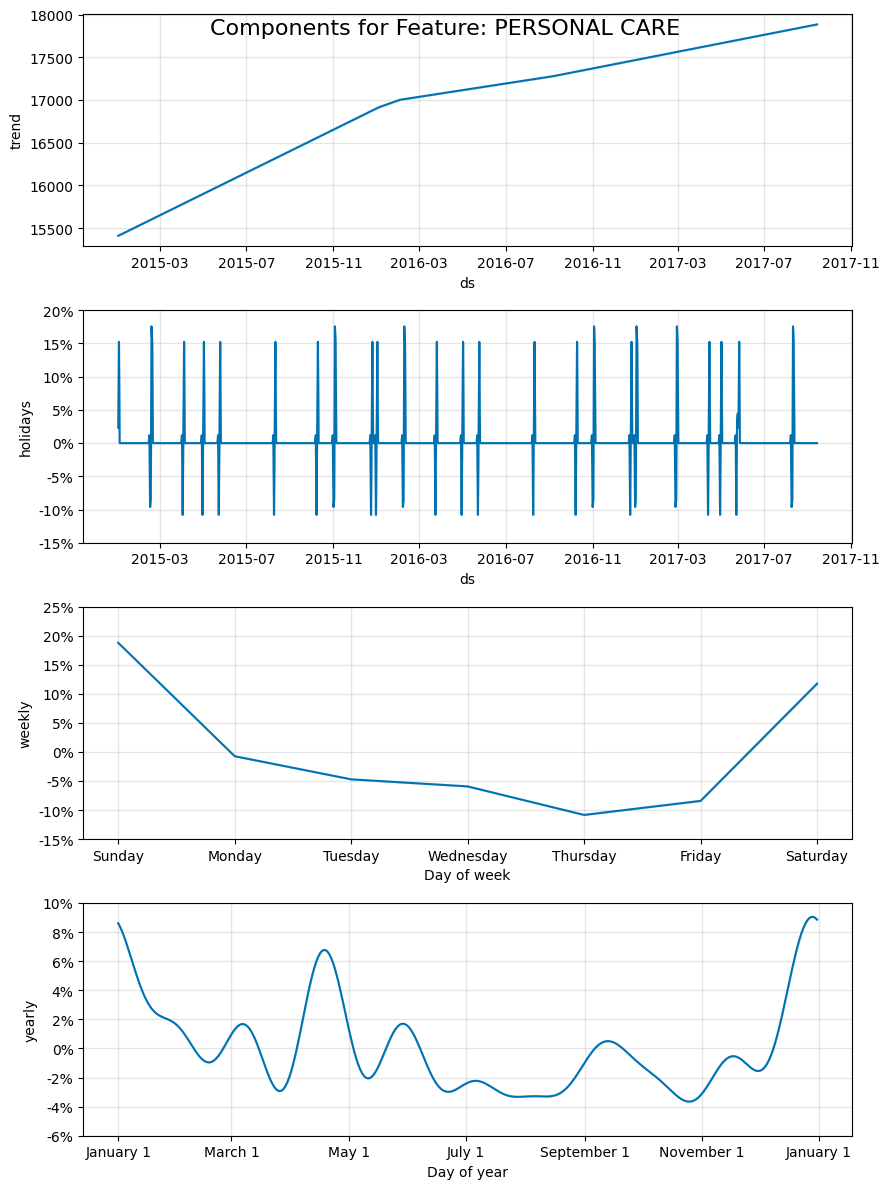

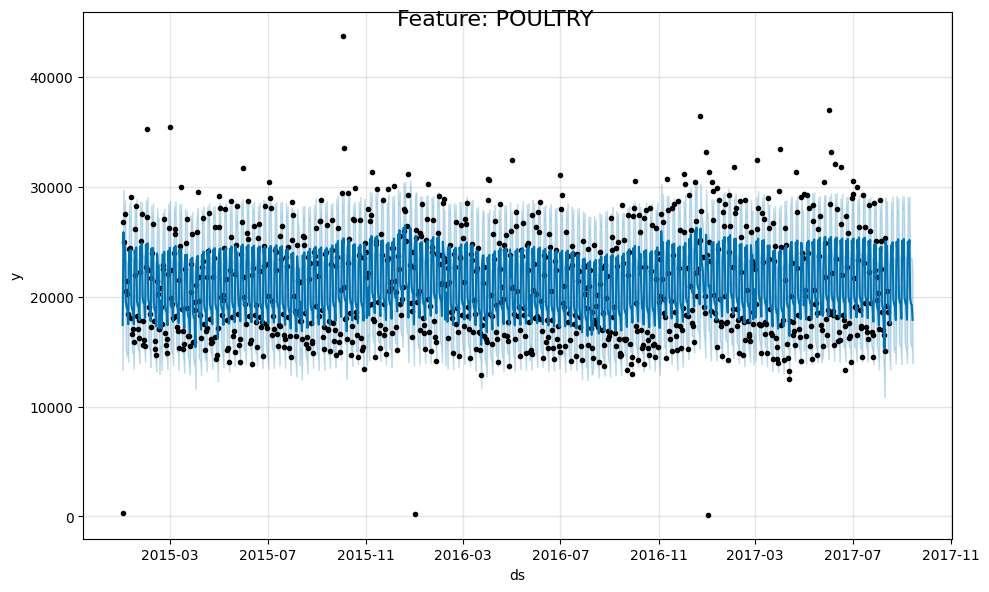

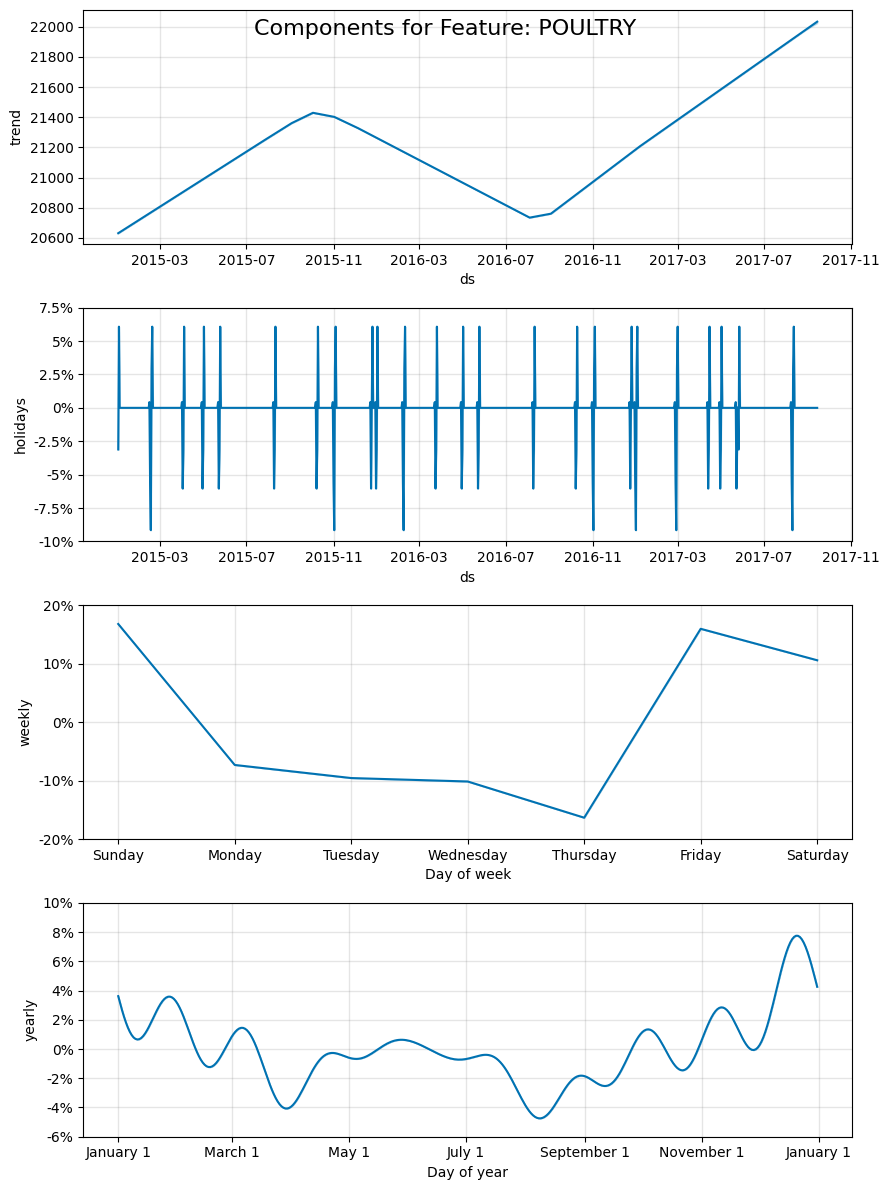

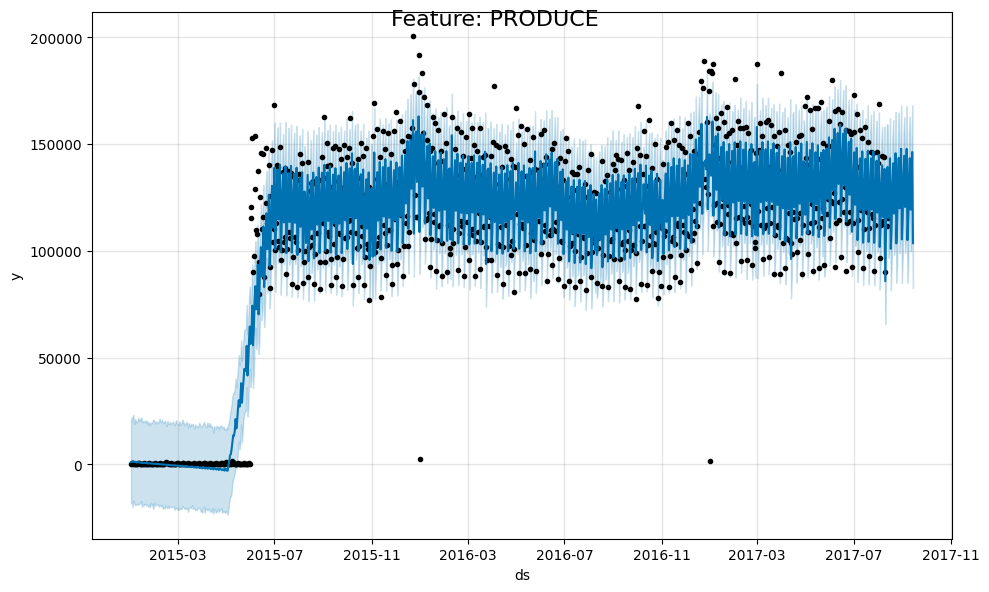

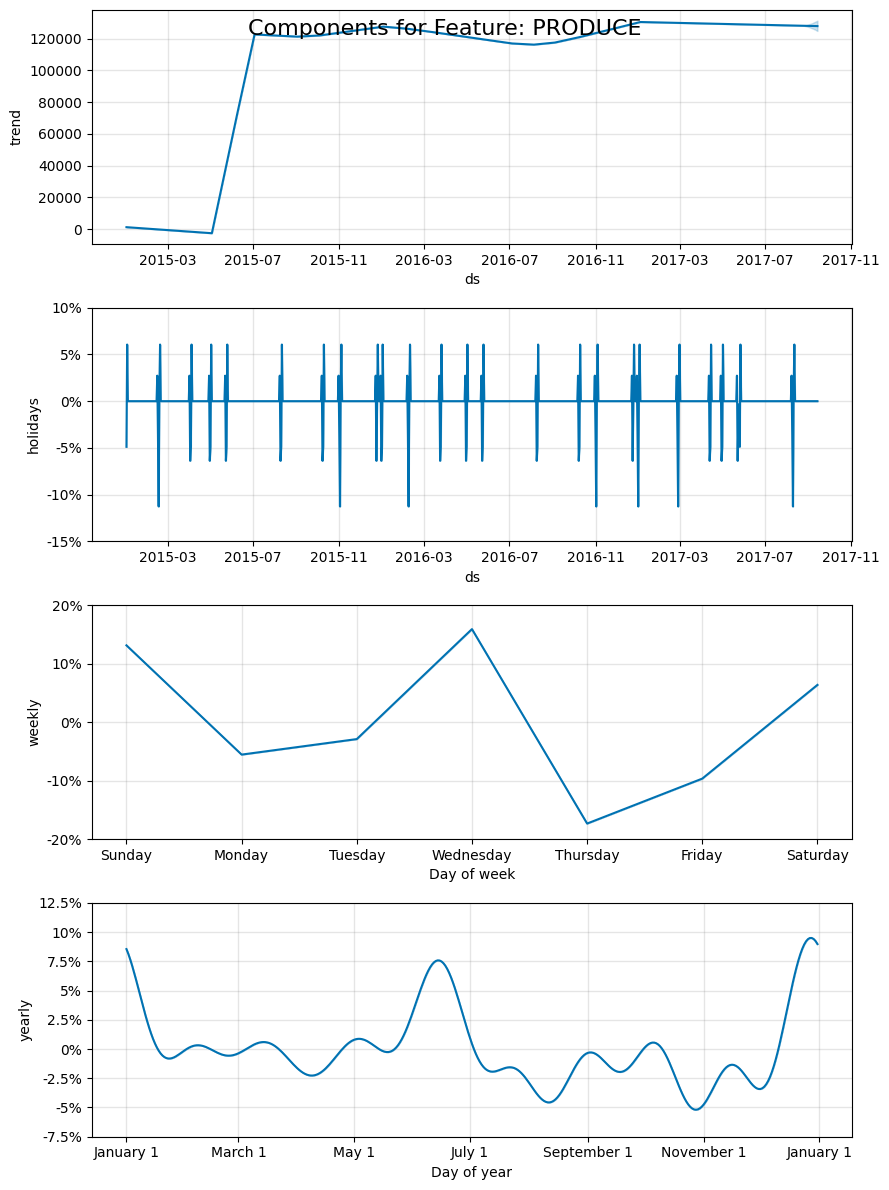

In [87]:
# Directory to save models
model_save_dir = "./saved_models"
os.makedirs(model_save_dir, exist_ok=True)

# Define prediction settings
prediction_days = 30
forecast_start_date = date(2017, 7, 1)
forecast_start_date = forecast_start_date.strftime('%Y-%m-%d')

forecasted_features = []

# Loop through each column in df
for column in df.columns:
    print(f"Processing feature: {column}")

    # Prepare data
    category_df = df[[column]].copy()
    category_df["ds"] = pd.to_datetime(date_df["date"])
    category_df.rename(columns={column: 'y'}, inplace=True)
    
    # Train the Prophet model
    m = Prophet(changepoint_prior_scale=best_params_dict[column]['changepoint_prior_scale'],
                seasonality_prior_scale=best_params_dict[column]['seasonality_prior_scale'],
                seasonality_mode='multiplicative',
                holidays=holiday_df)
    
    m.fit(category_df)

    # Save the trained model
    sanitized_feature = column.replace("/", "_").replace("\\", "_")
    model_path = os.path.join(model_save_dir, f"{sanitized_feature}_prophet_model.pkl")
    with open(model_path, 'wb') as f:
        pickle.dump(m, f)
    print(f"Saved model for feature: {column} at {model_path}")

    # Generate future dates and make predictions
    future = m.make_future_dataframe(periods=prediction_days)
    forecast = m.predict(future)
    
    # Filter forecasted dates
    forecasted_dates_df = forecast[forecast['ds'] >= forecast_start_date]
    predicted_df = forecasted_dates_df[['ds', 'yhat']]
    
    # Evaluate the model
    df_produce_copy = category_df.rename(columns={'y': 'ytrue'})
    df_result = predicted_df.merge(df_produce_copy)
    mape = mean_absolute_percentage_error(df_result['ytrue'], df_result['yhat'])
    print(f"Feature: {column}, MAPE: {mape:.4f}")
    
    # Plot forecasts and components
    fig1 = m.plot(forecast)
    fig1.suptitle(f"Feature: {column}", fontsize=16)
    fig2 = m.plot_components(forecast)
    fig2.suptitle(f"Components for Feature: {column}", fontsize=16)
    forecasted_features.append(forecasted_dates_df)

# Save all forecasts if needed
print("All models and forecasts completed.")


In [93]:
feature = "BREAD_BAKERY"
model_path = f"./saved_models/{feature}_prophet_model.pkl"

with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)
print(f"Loaded model for feature: {feature}")

Loaded model for feature: BREAD_BAKERY
